In [1]:
import pandas as pd
df = pd.read_csv('tep_original_trainset_seed10.csv',index_col=0).reset_index(drop=True)
print(df.shape)
df.head()

(7581, 55)


,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,262,262,0.21906,3644.9,4564.0,9.4741,27.150,41.925,2708.7,...,53.692,21.260,61.646,22.850,43.093,41.635,49.427,48.886,40.885,18.519
1,0,262,286,0.25735,3633.6,4550.2,9.2276,27.205,42.333,2711.2,...,53.419,25.093,62.136,22.746,35.574,42.402,44.930,46.437,41.294,17.145
2,0,262,295,0.24069,3661.4,4474.5,9.3000,26.468,42.275,2709.1,...,53.868,23.666,59.950,22.253,42.108,37.222,42.565,46.417,41.021,17.702
3,0,262,318,0.23227,3717.0,4476.5,9.2779,26.899,42.153,2695.3,...,54.029,23.084,58.714,21.563,40.654,38.376,45.497,46.466,41.257,18.055
4,0,262,323,0.25705,3666.4,4454.8,9.3565,26.766,42.511,2696.7,...,53.651,25.561,59.252,21.554,39.992,40.192,47.248,45.993,40.942,21.179


In [2]:
# split the df into data (for training) and target
data = df.iloc[:,3:].to_numpy()
target = df['faultNumber'].to_numpy()

In [3]:
# split the data into train and test sets
from sklearn.model_selection import train_test_split
# train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target, random_state=42)
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target, random_state=42)
print(train_input.shape, test_input.shape)

(6064, 52) (1517, 52)


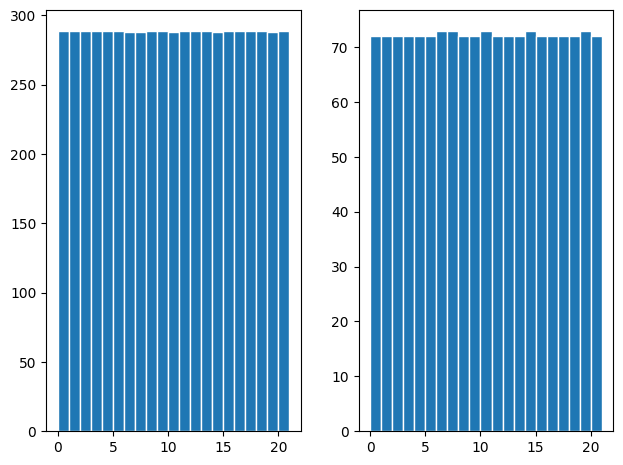

In [5]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)
fig.tight_layout()
axs[0].hist(train_target, edgecolor='w', bins=range(0,22))
axs[1].hist(test_target, edgecolor='w', bins=range(0,22))
plt.show()

In [6]:
# scaling - which is not required for tree models..
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

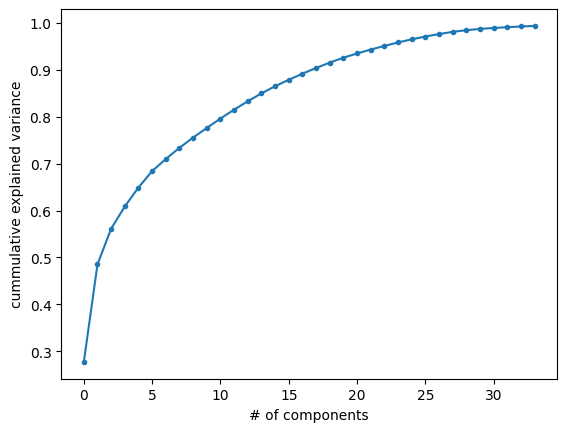

In [8]:
# combined with pca
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(n_components=34)
pca.fit(train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_),'.-')
plt.xlabel('# of components')
plt.ylabel('cummulative explained variance')
plt.show()

In [10]:
# 4. gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_scaled, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9772426640345614 0.7028352093247247


In [12]:
# will go with n_components=10
pca = PCA(n_components=30)
pca.fit(train_scaled)
tep_pca = pca.transform(train_scaled)

gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, tep_pca, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9337895671896378 0.5122026506030652


In [13]:
len(data)

7581

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
tep_tsne = tsne.fit_transform(data)

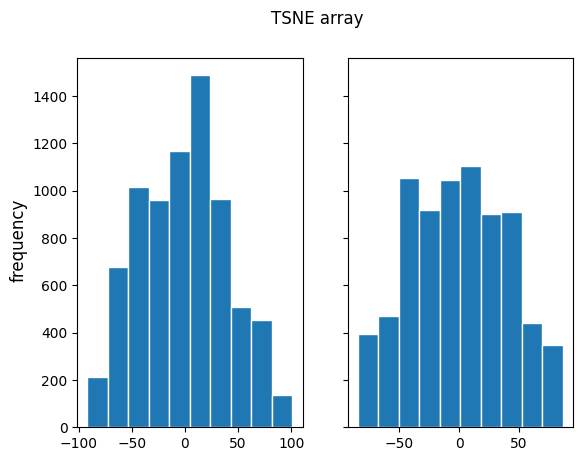

In [24]:
fig, axs = plt.subplots(1,2, sharey=True)
axs[0].hist(tep_tsne[:,0], edgecolor='w')
axs[1].hist(tep_tsne[:,1], edgecolor='w')
fig.suptitle('TSNE array')
# fig.supxlabel('XLAgg')
fig.supylabel('frequency')
plt.show()

In [21]:
print(tep_tsne[:,0].shape, tep_tsne[:,1].shape)

(7581,) (7581,)


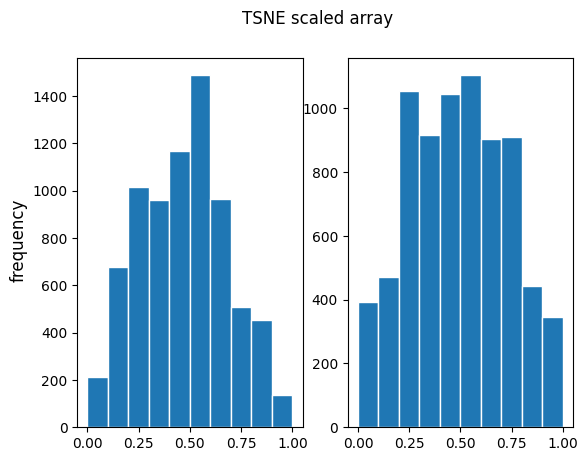

In [33]:
# hard to plot them due to large variance. to solve this issue, use MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# the zero column
mm = MinMaxScaler()
tep0 = mm.fit_transform(tep_tsne[:,0].reshape(-1,1))

# the first column
mm = MinMaxScaler()
tep1 = mm.fit_transform(tep_tsne[:,1].reshape(-1,1))

fig, axs = plt.subplots(1,2)
axs[0].hist(tep0, edgecolor='w')
axs[1].hist(tep1, edgecolor='w')
fig.suptitle('TSNE scaled array')
# fig.supxlabel('XLAgg')
fig.supylabel('frequency')
plt.show()

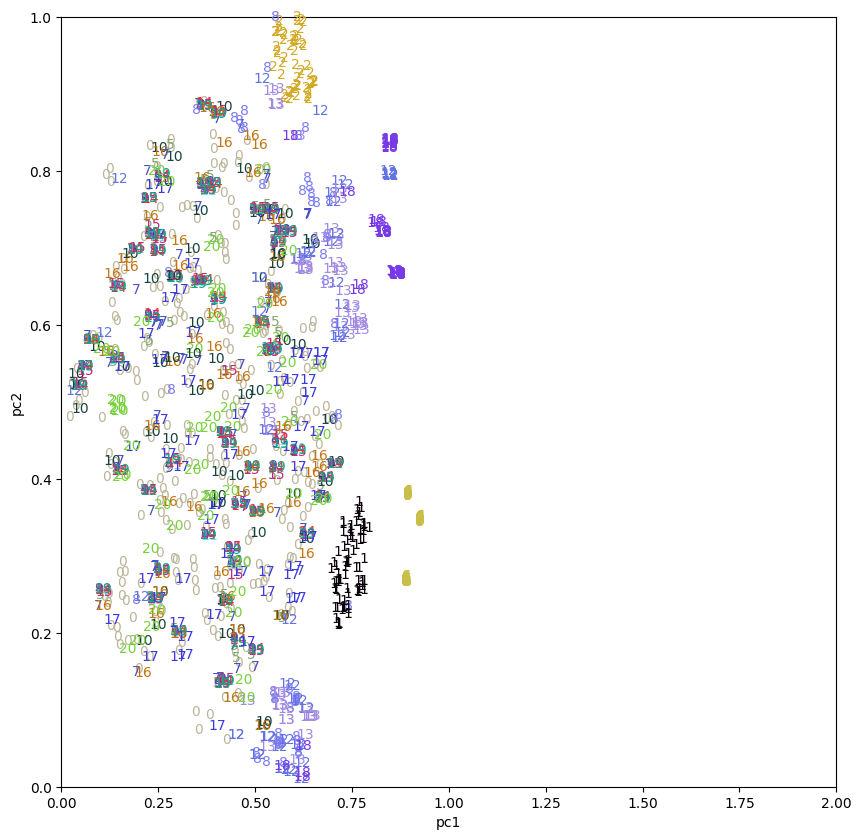

In [48]:
plt.figure(figsize=(10,10))
plt.xlim(tep0.min(), tep0.max()+1)
plt.xlim(tep1.min(), tep1.max()+1)
colors = ['#bcb59a','#0d030d','#d3a823','#21574e','#815e95','#82a872','#c9bf48','#4b51c7','#7c7cf2','#4a4cba','#16433d',
          '#88d2e6','#6273e4','#a28ce2','#fa2d22','#c5297c','#c27511','#3c39e1','#783ae7','#0da68c','#77d23c']
for i in range(int(len(data)/5)):
    plt.text(tep0[i], tep1[i], str(target[i]), color=colors[target[i]])
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()

(6064, 52) (1517, 52)


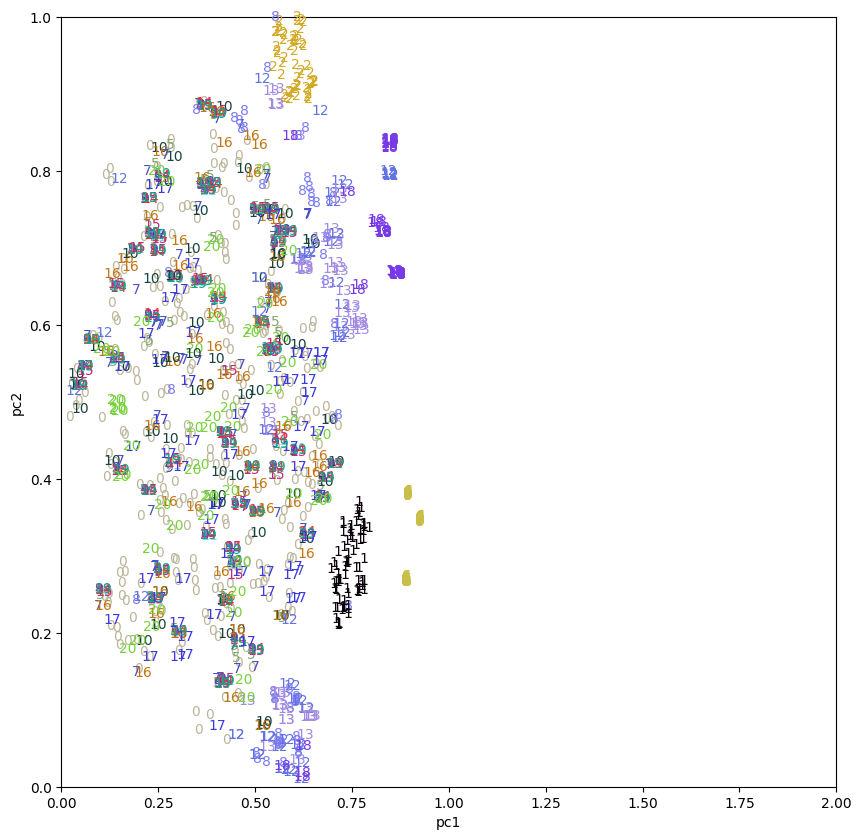

In [49]:
# try another dataset
df = pd.read_csv('tep_original_trainset_seed10.csv',index_col=0).reset_index(drop=True)

# split the df into data (for training) and target
data = df.iloc[:,3:].to_numpy()
target = df['faultNumber'].to_numpy()

# split the data into train and test sets
from sklearn.model_selection import train_test_split
# train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target, random_state=42)
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target, random_state=42)
# print(train_input.shape, test_input.shape)

from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
tep_tsne = tsne.fit_transform(data)

# hard to plot them due to large variance. to solve this issue, use MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# the zero column
mm = MinMaxScaler()
tep0 = mm.fit_transform(tep_tsne[:,0].reshape(-1,1))

# the first column
mm = MinMaxScaler()
tep1 = mm.fit_transform(tep_tsne[:,1].reshape(-1,1))

plt.figure(figsize=(10,10))
plt.xlim(tep0.min(), tep0.max()+1)
plt.xlim(tep1.min(), tep1.max()+1)
colors = ['#bcb59a','#0d030d','#d3a823','#21574e','#815e95','#82a872','#c9bf48','#4b51c7','#7c7cf2','#4a4cba','#16433d',
          '#88d2e6','#6273e4','#a28ce2','#fa2d22','#c5297c','#c27511','#3c39e1','#783ae7','#0da68c','#77d23c']
for i in range(int(len(data)/5)):
    plt.text(tep0[i], tep1[i], str(target[i]), color=colors[target[i]])
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()